In [1]:
import os
import pandas as pd
import warnings
from PIL import Image
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import transforms
import torchvision.models as models
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
split_char = '/' if os.name == 'posix' else '\\'

In [2]:
label_path = 'train_relationships.csv'
label_df = pd.read_csv(label_path)
label_df.info()

VAL_FAM = "F09"

# Get all image paths
all_img = [os.path.join(root, f) for root, _, files in os.walk('train') for f in files]

# Set validation flag and label
label_df['val'] = label_df['p1'].str.contains(VAL_FAM).astype(int)
label_df['label'] = 1

# Count train and validation positive samples
train_pos = (label_df['val'] == 0).sum()
val_pos = len(label_df) - train_pos

print(f"Train Positive: {train_pos}, Validation Positive: {val_pos}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598 entries, 0 to 3597
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   p1      3598 non-null   object
 1   p2      3598 non-null   object
dtypes: object(2)
memory usage: 56.3+ KB
Train Positive: 3296, Validation Positive: 302


In [3]:
def sample_neg(all_img,split_char):
    while True:
        img1, img2 = random.sample(all_img, 2)
        family1, person1 = img1.split(split_char)[1:3]
        family2, person2 = img2.split(split_char)[1:3]
        if family1 != family2:
            return f"{family1}/{person1}", f"{family2}/{person2}"

neg_samples = [sample_neg(all_img,split_char) for _ in range(train_pos)]


In [4]:
neg_df = pd.DataFrame(neg_samples,columns=['p1','p2'])
neg_df['label'] = 0
neg_df['val'] = neg_df['p1'].str.contains(VAL_FAM).astype(int)
train_neg = neg_df[neg_df['val']==0].count()['p1']
val_neg = len(neg_df) - train_neg
final_df = pd.concat([label_df,neg_df])

In [5]:
def check_dir_exists_and_nonempty(path):
    full_path = os.path.join('train', path)
    return os.path.isdir(full_path) and len(os.listdir(full_path)) > 0

final_df = final_df[
    final_df['p1'].apply(check_dir_exists_and_nonempty) &
    final_df['p2'].apply(check_dir_exists_and_nonempty)
]

In [6]:
train_df = final_df[final_df['val']==0]
val_df = final_df[final_df['val']==1]

print(f"Train Positive: {train_pos}, Train Negative: {train_neg}")
print(f"Validation Positive: {val_pos}, Validation Negative: {val_neg}")

Train Positive: 3296, Train Negative: 2969
Validation Positive: 302, Validation Negative: 327


In [7]:
train_transformation = transforms.Compose([
                                     transforms.Resize(255),
                                     transforms.RandomCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                     transforms.RandomErasing(),
                                    ])
valid_transformation = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

In [8]:
class MyDataset(Dataset):
    def __init__(self,root_path,df,transforms=None):
        super(MyDataset,self).__init__()
        self.df = df
        self.root_path = root_path
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        p1 = self.df.iloc[idx]['p1']
        p2 = self.df.iloc[idx]['p2']
        label = self.df.iloc[idx]['label']
        
        p1_path = os.path.join(self.root_path,p1)
        p2_path = os.path.join(self.root_path,p2)
        
        p1_sample = random.sample([os.path.join(p1_path,img) for img in os.listdir(p1_path)],1)[0]
        p2_sample = random.sample([os.path.join(p2_path,img) for img in os.listdir(p2_path)],1)[0]
            
        img1 = Image.open(p1_sample).convert('RGB')
        img2 = Image.open(p2_sample).convert('RGB')
        
        if self.transforms:
            img1 = self.transforms(img1)
            img2 = self.transforms(img2)
            
        return img1,img2,label
    
img_root = 'train'
train_data = MyDataset(img_root,train_df,train_transformation)
val_data = MyDataset(img_root,val_df,valid_transformation)

In [9]:
weights_path = 'resnet50-0676ba61.pth'
resnet = models.resnet50()
resnet.load_state_dict(torch.load(weights_path))
resnet_truncated = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet_truncated.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [10]:
class SiameseNet(nn.Module):
    def __init__(self, base_model):
        super(SiameseNet, self).__init__()
        self.base_model = base_model
        self.feature_dim = 2048  # Assuming ResNet50 output

        self.fc = nn.Sequential(
            nn.Linear(self.feature_dim * 4, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
    
    def forward(self, img1, img2):
        feat1 = self.base_model(img1).view(-1, self.feature_dim)
        feat2 = self.base_model(img2).view(-1, self.feature_dim)
        feat1 = feat1 * 2
        feat2 = feat2 * 2

        abs_diff = torch.abs(feat1 - feat2)
        prod = feat1 * feat2
        combined_features = torch.cat([feat1, feat2, abs_diff, prod], dim=1)

        return self.fc(combined_features)

In [11]:
def train_epoch(model, train_loader, criterion, optimizer, device, config):
    model.train()
    total_num = 0
    corrected_num = 0
    total_loss = 0
    
    for train_img1, train_img2, train_label in tqdm(train_loader, desc="Training",total = len(train_loader)//config['batch_size']):
        train_img1, train_img2, train_label = train_img1.to(device), train_img2.to(device), train_label.to(device)
        
        optimizer.zero_grad()
        output = model(train_img1, train_img2)
        loss = criterion(output, train_label)
        loss.backward()
        optimizer.step()
        
        total_num += train_label.shape[0]
        total_loss += train_label.shape[0] * loss.item()
        predicted = output.argmax(dim=-1)
        corrected_num += (predicted == train_label).sum().item()
    
    return total_loss / total_num, corrected_num / total_num

def validate(model, val_loader, criterion, device,config):
    model.eval()
    val_num = 0
    val_correct = 0
    val_loss = 0
    
    with torch.no_grad():
        for val_img1, val_img2, val_label in tqdm(val_loader, desc="Validating",total = len(val_loader)//config['batch_size']):
            val_img1, val_img2, val_label = val_img1.to(device), val_img2.to(device), val_label.to(device)
            val_output = model(val_img1, val_img2)
            val_loss += criterion(val_output, val_label).item() * val_label.shape[0]
            val_predicted = val_output.argmax(dim=-1)
            val_correct += (val_predicted == val_label).sum().item()
            val_num += val_label.shape[0]
    
    return val_loss / val_num, val_correct / val_num

def train_model(model, train_loader, val_loader, config):
    device = config['device']
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    train_loss_plot, train_acc_plot = [], []
    val_loss_plot, val_acc_plot = [], []
    best_val_loss = float('inf')

    for epoch in trange(config['epochs'], desc="Epochs"):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, config)
        val_loss, val_acc = validate(model, val_loader, criterion, device, config)
        
        scheduler.step(val_loss)
        
        train_loss_plot.append(train_loss)
        train_acc_plot.append(train_acc)
        val_loss_plot.append(val_loss)
        val_acc_plot.append(val_acc)

        print(f'Epoch: {epoch+1}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), config['save_path'])
            print(f"Model saved to '{config['save_path']}'")
    
    return train_loss_plot, train_acc_plot, val_loss_plot, val_acc_plot

In [12]:
# Hyperparameters and configuration
config = {
    'learning_rate': 0.0001,
    'weight_decay': 5e-4,
    'epochs': 20,
    'batch_size': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'save_path': 'SiameseNet_best.pth'
}

# Create model and data loaders
model = SiameseNet(resnet_truncated)
train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=False)

# Train the model
train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, config)

Training: 95it [01:04,  1.47it/s]:00<?, ?it/s]
Validating: 10it [00:02,  3.85it/s]
Epochs:   5%|▌         | 1/20 [01:07<21:23, 67.57s/it]

Epoch: 1: Train Loss: 0.7064 Train Acc: 0.5917 Val Loss: 0.6175 Val Acc: 0.6629
Model saved to 'SiameseNet_best.pth'


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.94it/s]
Epochs:  10%|█         | 2/20 [02:14<20:05, 66.97s/it]

Epoch: 2: Train Loss: 0.6543 Train Acc: 0.6348 Val Loss: 0.6333 Val Acc: 0.6517


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.93it/s]
Epochs:  15%|█▌        | 3/20 [03:21<18:59, 67.05s/it]

Epoch: 3: Train Loss: 0.6187 Train Acc: 0.6601 Val Loss: 0.5765 Val Acc: 0.7030
Model saved to 'SiameseNet_best.pth'


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.86it/s]
Epochs:  20%|██        | 4/20 [04:28<17:52, 67.03s/it]

Epoch: 4: Train Loss: 0.5855 Train Acc: 0.6873 Val Loss: 0.5784 Val Acc: 0.7063


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.92it/s]
Epochs:  25%|██▌       | 5/20 [05:35<16:46, 67.09s/it]

Epoch: 5: Train Loss: 0.5760 Train Acc: 0.6938 Val Loss: 0.5745 Val Acc: 0.6934
Model saved to 'SiameseNet_best.pth'


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.96it/s]
Epochs:  30%|███       | 6/20 [06:42<15:39, 67.13s/it]

Epoch: 6: Train Loss: 0.5702 Train Acc: 0.7052 Val Loss: 0.5562 Val Acc: 0.7175
Model saved to 'SiameseNet_best.pth'


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.96it/s]
Epochs:  35%|███▌      | 7/20 [07:49<14:31, 67.04s/it]

Epoch: 7: Train Loss: 0.5436 Train Acc: 0.7205 Val Loss: 0.5600 Val Acc: 0.6886


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.94it/s]
Epochs:  40%|████      | 8/20 [08:56<13:24, 67.07s/it]

Epoch: 8: Train Loss: 0.5328 Train Acc: 0.7297 Val Loss: 0.5234 Val Acc: 0.7416
Model saved to 'SiameseNet_best.pth'


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.91it/s]
Epochs:  45%|████▌     | 9/20 [10:03<12:18, 67.11s/it]

Epoch: 9: Train Loss: 0.5269 Train Acc: 0.7389 Val Loss: 0.4813 Val Acc: 0.7560
Model saved to 'SiameseNet_best.pth'


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.96it/s]
Epochs:  50%|█████     | 10/20 [11:10<11:10, 67.08s/it]

Epoch: 10: Train Loss: 0.5205 Train Acc: 0.7420 Val Loss: 0.4767 Val Acc: 0.7512
Model saved to 'SiameseNet_best.pth'


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.90it/s]
Epochs:  55%|█████▌    | 11/20 [12:18<10:03, 67.11s/it]

Epoch: 11: Train Loss: 0.5214 Train Acc: 0.7390 Val Loss: 0.5128 Val Acc: 0.7432


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.97it/s]
Epochs:  60%|██████    | 12/20 [13:25<08:56, 67.08s/it]

Epoch: 12: Train Loss: 0.5094 Train Acc: 0.7524 Val Loss: 0.5078 Val Acc: 0.7352


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  4.02it/s]
Epochs:  65%|██████▌   | 13/20 [14:32<07:49, 67.13s/it]

Epoch: 13: Train Loss: 0.4886 Train Acc: 0.7617 Val Loss: 0.5153 Val Acc: 0.7384


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.94it/s]
Epochs:  70%|███████   | 14/20 [15:38<06:41, 66.97s/it]

Epoch 00014: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 14: Train Loss: 0.4835 Train Acc: 0.7662 Val Loss: 0.5445 Val Acc: 0.7303


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.82it/s]
Epochs:  75%|███████▌  | 15/20 [16:45<05:34, 66.97s/it]

Epoch: 15: Train Loss: 0.4609 Train Acc: 0.7877 Val Loss: 0.5059 Val Acc: 0.7368


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.87it/s]
Epochs:  80%|████████  | 16/20 [17:52<04:27, 66.90s/it]

Epoch: 16: Train Loss: 0.4403 Train Acc: 0.8008 Val Loss: 0.5088 Val Acc: 0.7432


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.95it/s]
Epochs:  85%|████████▌ | 17/20 [18:59<03:20, 66.91s/it]

Epoch: 17: Train Loss: 0.4393 Train Acc: 0.7949 Val Loss: 0.4702 Val Acc: 0.7689
Model saved to 'SiameseNet_best.pth'


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.98it/s]
Epochs:  90%|█████████ | 18/20 [20:06<02:13, 66.86s/it]

Epoch: 18: Train Loss: 0.4157 Train Acc: 0.8070 Val Loss: 0.5107 Val Acc: 0.7512


Training: 95it [01:04,  1.48it/s]
Validating: 10it [00:02,  3.92it/s]
Epochs:  95%|█████████▌| 19/20 [21:13<01:06, 66.82s/it]

Epoch: 19: Train Loss: 0.4282 Train Acc: 0.7965 Val Loss: 0.4760 Val Acc: 0.7737


Training: 95it [01:04,  1.47it/s]
Validating: 10it [00:02,  3.92it/s]
Epochs: 100%|██████████| 20/20 [22:20<00:00, 67.01s/it]

Epoch: 20: Train Loss: 0.4125 Train Acc: 0.8038 Val Loss: 0.4648 Val Acc: 0.7833
Model saved to 'SiameseNet_best.pth'


In [ ]:
torch.save(model.state_dict(), 'final.pth')

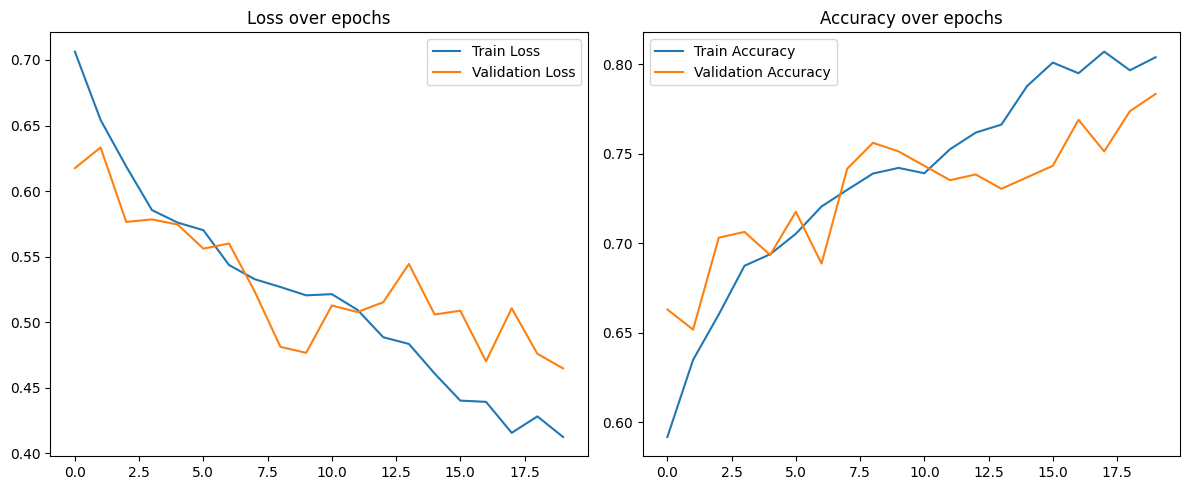

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
class MyTestDataset(Dataset):
    def __init__(self,root_path,df,transforms=None):
        super(MyTestDataset,self).__init__()
        self.df = df
        self.root_path = root_path
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        p1 = self.df.iloc[idx]['p1']
        p2 = self.df.iloc[idx]['p2']
        
        
        p1_path = os.path.join(self.root_path,p1)
        p2_path = os.path.join(self.root_path,p2)
        
        img1 = Image.open(p1_path).convert('RGB')
        img2 = Image.open(p2_path).convert('RGB')
        
        if self.transforms:
            img1 = self.transforms(img1)
            img2 = self.transforms(img2)
            
        return img1,img2
    


def test_csv(test_name,img_root_path,test_list_path,test_label_path):
    test_root_path = img_root_path
    test_path = test_list_path
    test_df = pd.read_csv(test_path)
    test_data = MyTestDataset(test_root_path,test_df,valid_transformation)
    test_loader = DataLoader(test_data,shuffle=False,batch_size = 64)
    result = []
    for batch_i,(test_batch1,test_batch2) in tqdm(enumerate(test_loader)):
        test_batch1,test_batch2 = test_batch1.to(device),test_batch2.to(device)
        output = model(test_batch1,test_batch2).argmax(dim=-1)
        output = output.detach().cpu().numpy().tolist()
        result.extend(output)
    truth_path = test_label_path
    test_truth_df = pd.read_csv(truth_path)
    test_truth = test_truth_df['label'].to_numpy().tolist()
    test_accuracy = accuracy_score(test_truth,result) * 100
    print(f'Test file: {test_name}, test accuracy is: {test_accuracy:2.1f}')


test_img_path = 'test-private-faces'
test_info_path = 'test-private-lists'
test_label_path = 'test-private-labels'
test_dict = {}
for dir,_,test_list in os.walk(test_info_path):
    for f in test_list:
        if f.endswith('.csv'):
            list_name = f.replace('.csv','')
            if list_name not in test_dict:
                test_dict[list_name] = [os.path.join(dir,f)]
            else:
                test_dict[list_name].append(os.path.join(dir,f))
for dir,_,test_list in os.walk(test_label_path):
    for f in test_list:
        if f.endswith('.csv'):
            list_name = f.replace('.csv','')
            if list_name not in test_dict:
                test_dict[list_name] = [os.path.join(dir,f)]
            else:
                test_dict[list_name].append(os.path.join(dir,f))
for k,v in test_dict.items():
    if k != 'fd':
        test_csv(k,test_img_path,v[0],v[1])

75it [00:19,  3.86it/s]


Test file: ss, test accuracy is: 66.9


232it [00:58,  3.97it/s]


Test file: ms, test accuracy is: 61.9


25it [00:06,  4.00it/s]


Test file: gfgs, test accuracy is: 54.7


152it [00:38,  3.95it/s]


Test file: sibs, test accuracy is: 61.6


23it [00:05,  3.94it/s]


Test file: gmgs, test accuracy is: 58.8


284it [01:12,  3.94it/s]


Test file: fs, test accuracy is: 59.8


14it [00:03,  4.12it/s]


Test file: gfgd, test accuracy is: 56.0


225it [00:57,  3.94it/s]


Test file: md, test accuracy is: 61.6


15it [00:03,  3.98it/s]


Test file: gmgd, test accuracy is: 58.4


285it [01:11,  3.97it/s]

Test file: bb, test accuracy is: 57.5
